In [37]:
#Standard Imports
import geopandas as gpd
from tqdm import tqdm
import random
#import libpysal as lp
import json
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import gerrychain as gc
import numpy as np
#GerryChain Imports   #"import gerrychain as gc" to import the entire package
from gerrychain import (
    Election,
    Graph,
    MarkovChain, #importing things from the Gerrychain package
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges 
from gerrychain.tree import recursive_tree_part, bipartition_tree_random
from functools import partial
#Above are just the syntax for importing those parameters


In [38]:
#Load in processed schools data
schools_processed = gpd.read_file('data/new_Schools_2017_2018.json', driver='GeoJSON')


In [39]:
#Load in processed spa data
spas_processed = gpd.read_file('data/new_SPAs_2017_2018.json', driver='GeoJSON')

In [40]:
#SPA columns
spas_processed.iloc[0]

OBJECTID                                                     1
COUNT_                                                       5
SPA                                                     WL03.4
ELEM_                                                      126
INT_                                                       205
                                   ...                        
TOT_POP_B                                                    2
TOT_POP_H                                                    7
TOT_POP_N                                                    0
TOT_POP_P                                                    0
geometry     POLYGON ((11725868.08642839 7152149.053798078,...
Name: 0, Length: 75, dtype: object

In [41]:
#List of elem schools

schools_processed[schools_processed["ELEM_"]!=0]

,OBJECTID,SCH_CODE,CLASS,SCH_NUM,NAME,DATE_OPENE,BUILDING_D,CLASSROOMS,SPECIAL_SI,TRAILERS,...,ELEM_,INT_,MID_,HIGH_,CAPACITY,PERM_CLRM,PORT_CLRM,SPA,SCHOOL_TYP,geometry
0,1,HCA,CHARTER,119,HILLSBORO CHARTER ACADEMY,1966,7,6,0,0,...,119,0,0,0,0,6,0,WL53,,POINT (11704031.792 7120651.489)
1,2,MSE,ELEMENTARY,155,MOOREFIELD STATION ES,2013,46,48,0,0,...,155,0,0,0,1003,48,0,DN46.1,ES,POINT (11765618.438 7048564.331)
2,3,CTY,ELEMENTARY,111,COUNTRYSIDE ES,2003,39,40,0,0,...,111,0,0,0,815,40,0,EL05,ES,POINT (11791339.593 7064856.836)
3,4,HUT,ELEMENTARY,122,HUTCHISON FARM ES,2002,37,38,2,0,...,122,0,0,0,862,38,0,DS13,ES,POINT (11761074.023 7017323.603)
5,6,BUF,ELEMENTARY,152,BUFFALO TRAIL ES,2010,46,47,0,0,...,152,0,0,0,1039,47,0,DS12.3,ES,POINT (11754934.164 7012173.484)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,GPE,CONSTRUCTION,158,GOSHEN POST ES,2018,0,0,0,0,...,158,0,0,0,0,0,0,DS07.5,,POINT (11747954.989 7022035.497)
97,98,FDE,ELEMENTARY,153,FREDERICK DOUGLASS ES,2012,44,45,0,0,...,153,0,0,0,882,45,0,CL25.1,ES,POINT (11751612.319 7087674.585)
100,101,MTE,ELEMENTARY,157,MADISONS TRUST ES,2016,46,47,0,0,...,157,0,0,0,934,47,0,DN36.3,ES,POINT (11754701.010 7040573.519)
102,103,E24,PROFFER,198,UNNAMED ES-24,2024,0,0,0,0,...,198,0,0,0,0,0,0,CL34.1,,POINT (11757173.900 7077977.513)


In [42]:
#Build corresponding dual graph
graph = gc.Graph.from_geodataframe(spas_processed)

C:\Users\james\Anaconda3\lib\site-packages\gerrychain\graph\adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(322, 423), (383, 389), (49, 227), (94, 95), (196, 409), (70, 209), (177, 178), (272, 273), (433, 434), (64, 180), (226, 338), (332, 333), (47, 53), (303, 444), (38, 180), (18, 265), (0, 4), (303, 304), (19, 21), (50, 407), (52, 301), (212, 236), (98, 339), (277, 315), (233, 234), (196, 212), (427, 428), (13, 56), (199, 236), (241, 416), (95, 378), (145, 291), (21, 299), (266, 285), (71, 72), (176, 178), (30, 187), (84, 247), (6, 445), (278, 397), (316, 395), (13, 231), (242, 424), (20, 303), (141, 288), (83, 181), (20, 87), (51, 147), (65, 119), (279, 381), (328, 330), (345, 346), (403, 409), (244, 361), (7, 10), (214, 358), (30, 275), (277, 294), (103, 430), (332, 334), (87, 444), (196, 292), (332, 345), (345, 358), (265, 266), (393, 394), (357, 437), (234, 252), (99, 293), (277, 314), (149, 150), (75, 287), (0, 13), (51, 408), (408,

In [43]:
#Add centroids to graph for plotting purposes
centroids = spas_processed.centroid
spas_processed["C_X"] = centroids.x
spas_processed["C_Y"] = centroids.y


graph.add_data(spas_processed)

In [44]:
#Dual graph contents
graph.nodes[0]


{'boundary_node': True,
 'boundary_perim': 205.30322108969995,
 'area': 63993687.70828096,
 'OBJECTID': 1,
 'COUNT_': 5.0,
 'SPA': 'WL03.4',
 'ELEM_': 126,
 'INT_': 205,
 'HIGH_': 311,
 'ELEM_CODE': 'LOV',
 'MID_CODE': 'HRM',
 'HIGH_CODE': 'WHS',
 'DISTRICT': 'WL',
 'UTILITIES': 'WOU',
 'SHAPE_Leng': 47268.7885828,
 'SHAPE_Area': 63993837.1512,
 'STDYAREA_1': 'WL03.4',
 'DISTRICT_1': 'WL',
 'PLANNING_Z': 'WL03.4',
 'ELEM': 'LOV',
 'MID': 'HRM',
 'HIGH': 'WHS',
 'UTILITIE_1': 'WOU',
 'DISTRICT_2': 'WL',
 'MID_2018': 'HRM',
 'HIGH_2018': 'WHS',
 'PK': 2,
 'KG': 2,
 'GR1': 4,
 'GR2': 5,
 'GR3': 3,
 'GR4': 5,
 'GR5': 4,
 'GR6': 2,
 'GR7': 4,
 'GR8': 4,
 'GR9': 5,
 'GR10': 3,
 'GR11': 3,
 'GR12': 3,
 'TOTAL_KG_5': 23,
 'TOTAL_6_8': 10,
 'TOTAL_9_12': 14,
 'TOTAL_KG_1': 47,
 'TOTAL_PK_1': 49,
 'ELEM_POP': 23,
 'MID_POP': 10,
 'HIGH_POP': 14,
 'TOT_POP': 47,
 'ELEM_POP_A': 0,
 'ELEM_POP_W': 17,
 'ELEM_POP_M2': 0,
 'ELEM_POP_B': 2,
 'ELEM_POP_H': 4,
 'ELEM_POP_N': 0,
 'ELEM_POP_P': 0,
 'MID_PO

In [45]:
#Add nonWhite column for evaluation
for node in graph.nodes(): 
    graph.nodes[node]["ELEM_POP_nW"] = graph.nodes[node]["ELEM_POP"] - graph.nodes[node]["ELEM_POP_W"]

In [46]:
spas_processed["ELEM_CODE"].unique()
# color_dict = dict()
# i = 1
# for code in spas_processed["ELEM_CODE"].unique():
#     color_dict[code] = i
#     i = i+1
# color_dict    

array(['LOV', 'HAM', 'MTV', 'LUC', 'WAT', 'KWC', 'FHR', 'TOL', 'FDE',
       'LIB', 'BUF', 'SUG', 'STE', 'EME', 'MTE', 'BAL', 'CTY', 'STU',
       'MSE', 'CSP', 'GUI', 'EVE', 'LEE', 'LIN', 'RHL', 'CCE', 'CAT',
       'NLE', 'ARC', 'CRE', 'FOR', 'RLC', 'BAN', 'ALG', 'ASH', 'LOW',
       'HRZ', 'PNB', 'CED', 'BST', 'PMK', 'SAN', 'MEA', 'DOM', 'DIS',
       'HLS', 'SYC', 'MIL', 'RRD', 'SEL', 'LIT', 'ALD', 'LEG', 'HUT',
       'SUL'], dtype=object)

<IPython.core.display.Javascript object>


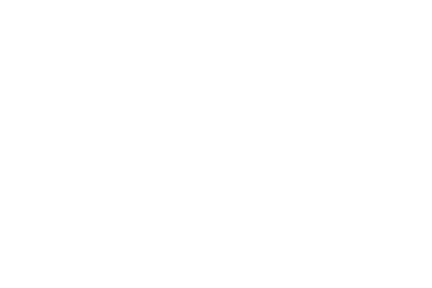

<IPython.core.display.Javascript object>


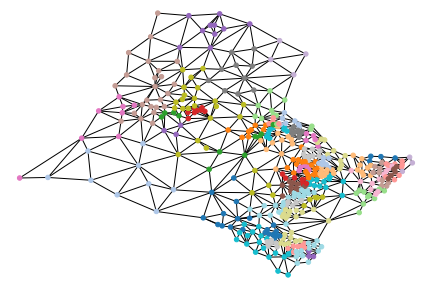

In [48]:
#Plot dual graph and current school districts
%matplotlib notebook 
%matplotlib inline
%matplotlib notebook
color_dict = dict()
i = 1
for code in spas_processed["ELEM_CODE"].unique():
    color_dict[code] = i
    i = i+1
     
nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[graph.nodes[node]["ELEM_CODE"]] for node in graph.nodes()],cmap='tab20',with_labels=True)
%matplotlib notebook
#commented out the first plot since there is no ELEM_2018 and the dict is longer
graph.add_edge(143,65)
nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [graph.nodes[node]["ELEM_"] for node in graph.nodes()],cmap='tab20')
plt.show()


### How can we check for discontiguous and unoccupied nodes?

In [12]:
#Node 392 is unoccupied but also discontiguous
graph.nodes[392]["ELEM_CODE"] = "MIL"

In [13]:
#Experimental
graph.nodes[392]

{'boundary_node': False,
 'area': 19749549.455430534,
 'OBJECTID': 395,
 'COUNT_': 4.0,
 'SPA': 'EL36.1',
 'ELEM_': 138,
 'INT_': 212,
 'HIGH_': 306,
 'ELEM_CODE': 'MIL',
 'MID_CODE': 'STM',
 'HIGH_CODE': 'PVH',
 'DISTRICT': 'EL',
 'UTILITIES': 'WU',
 'SHAPE_Leng': 25868.2281063,
 'SHAPE_Area': 19749549.4554,
 'STDYAREA_1': 'EL36.1',
 'DISTRICT_1': 'EL',
 'PLANNING_Z': 'EL36.1',
 'ELEM': 'STE',
 'MID': 'STM',
 'HIGH': 'PVH',
 'UTILITIE_1': 'WU',
 'DISTRICT_2': 'EL',
 'MID_2018': 'STM',
 'HIGH_2018': 'PVH',
 'PK': 0,
 'KG': 0,
 'GR1': 0,
 'GR2': 0,
 'GR3': 0,
 'GR4': 0,
 'GR5': 0,
 'GR6': 0,
 'GR7': 0,
 'GR8': 0,
 'GR9': 0,
 'GR10': 0,
 'GR11': 0,
 'GR12': 0,
 'TOTAL_KG_5': 0,
 'TOTAL_6_8': 0,
 'TOTAL_9_12': 0,
 'TOTAL_KG_1': 0,
 'TOTAL_PK_1': 0,
 'ELEM_POP': 0,
 'MID_POP': 0,
 'HIGH_POP': 0,
 'TOT_POP': 0,
 'ELEM_POP_A': 0,
 'ELEM_POP_W': 0,
 'ELEM_POP_M2': 0,
 'ELEM_POP_B': 0,
 'ELEM_POP_H': 0,
 'ELEM_POP_N': 0,
 'ELEM_POP_P': 0,
 'MID_POP_A': 0,
 'MID_POP_W': 0,
 'MID_POP_M2': 0,
 'M

In [14]:
#Troubleshooting contiguity
'''for part in current_districts.parts:
    sgraph = nx.subgraph(graph,current_districts.parts[part])
    print(part)
    nx.draw(sgraph, pos ={n:(sgraph.nodes[n]['C_X'],sgraph.nodes[n]['C_Y']) for n in sgraph.nodes()},node_size=20,node_color = [sgraph.nodes[node]["ELEM_"] for node in sgraph.nodes()],cmap='tab20')
    plt.show()'''


'for part in current_districts.parts:\n    sgraph = nx.subgraph(graph,current_districts.parts[part])\n    print(part)\n    nx.draw(sgraph, pos ={n:(sgraph.nodes[n][\'C_X\'],sgraph.nodes[n][\'C_Y\']) for n in sgraph.nodes()},node_size=20,node_color = [sgraph.nodes[node]["ELEM_"] for node in sgraph.nodes()],cmap=\'tab20\')\n    plt.show()'

In [15]:
#Setup helper functions to measure which school in which spa and what capacities are
school_container = {}
for index, row in schools_processed.iterrows():
    for node in graph.nodes(): 
        if row["SPA"] == graph.nodes[node]["STDYAREA_1"]:
            school_container[row["SCH_CODE"]] = node

school_capacities = {}

for index, row in schools_processed.iterrows():
    school_capacities[row["SCH_CODE"]] = row["CAPACITY"]
    
school_container['LOV']
print(sorted(list(school_container.values())))

#Used LOV here

[7, 11, 18, 18, 24, 26, 26, 26, 38, 50, 52, 60, 60, 61, 63, 64, 82, 85, 85, 85, 87, 91, 94, 94, 95, 96, 103, 107, 107, 108, 112, 117, 126, 127, 127, 135, 136, 142, 145, 150, 161, 176, 181, 181, 181, 182, 183, 183, 185, 197, 199, 205, 207, 207, 208, 208, 208, 215, 231, 245, 246, 246, 248, 256, 262, 264, 264, 273, 276, 296, 296, 299, 300, 301, 303, 303, 305, 310, 310, 316, 320, 322, 338, 343, 345, 345, 356, 359, 373, 374, 386, 398, 398, 401, 402, 403, 410, 410, 418, 420, 424, 425, 426, 429, 438]


In [16]:
#function for tracking overloads and setup updaters
def overload_tracker(partition):
    overloads = dict()
    for part in partition.parts.keys():
        overloads[part] = partition['population'][part] - school_capacities[part]
    return overloads

#positive bad negative good    

updater = { #an updater is basically what your interested in measuring
        "population": updaters.Tally("ELEM_POP", alias="population"),
    "A": updaters.Tally("ELEM_POP_A", alias="population"),
    "W": updaters.Tally("ELEM_POP_W", alias="population"),
    "M2": updaters.Tally("ELEM_POP_M2", alias="population"),
    "B": updaters.Tally("ELEM_POP_B", alias="population"),
    "H": updaters.Tally("ELEM_POP_H", alias="population"),
    "N": updaters.Tally("ELEM_POP_N", alias="population"),
    "P": updaters.Tally("ELEM_POP_P", alias="population"),
    "WnW": Election("WnW", {"White": "ELEM_POP_W", "nonWhite": "ELEM_POP_nW"}),
    "Overloads": overload_tracker,
    "cut_edges": cut_edges, #edges in the dual graph that are next to each other but belong in different districts.
            }


### I am not sure what the Election does here above?

In [17]:
#Evaluate data types
current_districts = Partition(graph,"ELEM_CODE",updater)
current_districts["WnW"].percents("White")

#white percentage for each district

(0.8052173913043478,
 0.8034682080924855,
 0.7732793522267206,
 0.5846153846153846,
 0.8148148148148148,
 0.8371212121212122,
 0.5791610284167794,
 0.5508474576271186,
 0.36149584487534625,
 0.3466787989080983,
 0.44090056285178236,
 0.13539967373572595,
 0.22014925373134328,
 0.7796976241900648,
 0.384297520661157,
 0.5533980582524272,
 0.4187256176853056,
 0.45429362880886426,
 0.32842582106455265,
 0.4868421052631579,
 0.0796875,
 0.47568710359408034,
 0.44466403162055335,
 0.8842105263157894,
 0.8065134099616859,
 0.24329501915708812,
 0.6543909348441926,
 0.4763271162123386,
 0.3814968814968815,
 0.31303418803418803,
 0.20282186948853614,
 0.1949828962371722,
 0.6606334841628959,
 0.6401766004415012,
 0.49093904448105435,
 0.6479591836734694,
 0.5579322638146168,
 0.3837471783295711,
 0.4544334975369458,
 0.5669172932330827,
 0.34210526315789475,
 0.597864768683274,
 0.3443396226415094,
 0.46321525885558584,
 0.37247924080664296,
 0.5056320400500626,
 0.6849673202614379,
 0.511520

In [18]:
#Check initial district overloads
print(current_districts["Overloads"])
sum(current_districts["Overloads"].values())

{'LOV': -7, 'HAM': -87, 'MTV': -88, 'LUC': 3, 'WAT': -124, 'KWC': -255, 'FHR': -83, 'TOL': -78, 'FDE': -160, 'LIB': 110, 'BUF': 560, 'SUG': -78, 'STE': -66, 'EME': -86, 'MTE': 34, 'BAL': -112, 'CTY': -46, 'STU': -163, 'MSE': -120, 'CSP': -66, 'GUI': -4, 'EVE': -159, 'LEE': -132, 'LIN': -43, 'RHL': -136, 'CCE': 104, 'CAT': -27, 'NLE': -227, 'ARC': 38, 'CRE': -47, 'FOR': -84, 'RLC': -86, 'BAN': -19, 'ALG': -205, 'ASH': -123, 'LOW': -145, 'HRZ': -232, 'PNB': -51, 'CED': -37, 'BST': -180, 'PMK': -137, 'SAN': -135, 'MEA': -122, 'DOM': -9, 'DIS': -183, 'HLS': 20, 'SYC': -77, 'MIL': -62, 'RRD': -169, 'SEL': -124, 'LIT': -175, 'ALD': 58, 'LEG': -6, 'HUT': -117, 'SUL': -163}


-4108

In [19]:
#Format of current districts
current_districts.parts

{'LOV': frozenset({0, 1, 4, 13, 56, 57, 58, 230, 231, 415}),
 'HAM': frozenset({2, 36, 40, 41, 43, 44, 46, 215}),
 'MTV': frozenset({3,
            5,
            35,
            39,
            49,
            53,
            54,
            86,
            97,
            218,
            227,
            229,
            232,
            243,
            244,
            321,
            322,
            335,
            336,
            396,
            398,
            399,
            422,
            423}),
 'LUC': frozenset({6, 7, 10, 445}),
 'WAT': frozenset({8, 9, 11, 12, 15, 30, 92, 187, 347, 348}),
 'KWC': frozenset({14,
            31,
            32,
            33,
            34,
            47,
            75,
            83,
            101,
            181,
            182,
            202,
            203,
            219,
            220,
            223,
            249,
            251,
            275,
            363,
            434}),
 'FHR': frozenset({16, 4

In [20]:
#helper functions for measuring acceptance into Markov chain
def contains(partition):
    
    #assign = dict(partition.assignment)
    
    for part in partition.parts.keys():
        if school_container[part] not in partition.parts[part]:
            return False
    
    return True

def capacities(partition):
    for part in partition.parts.keys():
        if partition["population"][part] > 600+school_capacities[part]:
            #print(part)
            return False
    return True
        
        
   #changed 300 to 600     

In [21]:
#Each district contains exactly 1 school building
contains(current_districts)

True

In [22]:
#All capacities are within 300 pupils of their limits
capacities(current_districts)

True

In [23]:
#checking outliers
# school_capacities["ALD"]

#Can you elaborate on this?

In [24]:
#current student assignment numbers
current_districts['population']

{'LOV': 575,
 'HAM': 173,
 'MTV': 741,
 'LUC': 325,
 'WAT': 162,
 'KWC': 528,
 'FHR': 739,
 'TOL': 708,
 'FDE': 722,
 'LIB': 1099,
 'BUF': 1599,
 'SUG': 613,
 'STE': 536,
 'EME': 463,
 'MTE': 968,
 'BAL': 618,
 'CTY': 769,
 'STU': 722,
 'MSE': 883,
 'CSP': 608,
 'GUI': 640,
 'EVE': 473,
 'LEE': 506,
 'LIN': 95,
 'RHL': 522,
 'CCE': 1044,
 'CAT': 706,
 'NLE': 697,
 'ARC': 962,
 'CRE': 936,
 'FOR': 567,
 'RLC': 877,
 'BAN': 221,
 'ALG': 453,
 'ASH': 607,
 'LOW': 588,
 'HRZ': 561,
 'PNB': 886,
 'CED': 812,
 'BST': 665,
 'PMK': 570,
 'SAN': 562,
 'MEA': 424,
 'DOM': 734,
 'DIS': 843,
 'HLS': 799,
 'SYC': 765,
 'MIL': 868,
 'RRD': 578,
 'SEL': 770,
 'LIT': 634,
 'ALD': 196,
 'LEG': 1026,
 'HUT': 745,
 'SUL': 459}

In [25]:
#school data row - checking capacity
schools_processed[schools_processed["SCH_CODE"]=="ALD"]

,OBJECTID,SCH_CODE,CLASS,SCH_NUM,NAME,DATE_OPENE,BUILDING_D,CLASSROOMS,SPECIAL_SI,TRAILERS,...,ELEM_,INT_,MID_,HIGH_,CAPACITY,PERM_CLRM,PORT_CLRM,SPA,SCHOOL_TYP,geometry
43,44,ALD,ELEMENTARY,101,ALDIE ES,1928,6,7,0,0,...,101,0,0,0,138,7,0,DS05,ES,POINT (11725952.484 7039034.020)


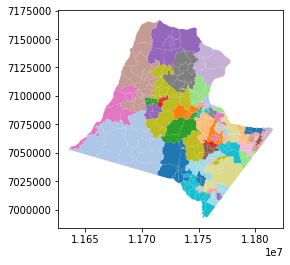

In [26]:
#plot of current districts
spas_processed.plot(column="ELEM_",cmap='tab20')

In [27]:
#checking contiguity of plan
constraints.single_flip_contiguous(current_districts)

False

### Can you elaborate on how to check for this to be TRUE since some assigned node seems to be absent?

In [28]:
#simple compactness bound to compare to initial map
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 1.1*len(current_districts["cut_edges"])
)


In [29]:
#Sample acceptance function to attempt to balance school populations
def overload_balancing(partition):

    if abs(sum(partition["Overloads"].values())) <= abs(sum(partition.parent["Overloads"].values())):
        return True
    else:
        if random.random() < .1:
            return True
        else:
            return False
        
def overload_decrease(partition):

    if abs(sum([x for x in partition["Overloads"].values() if x > 0])) <= abs(sum([x for x in partition.parent["Overloads"].values() if x > 0])):
        return True
    else:
        if random.random() < .1:
            return True
        else:
            return False        


In [30]:
#formulate recom proposal
ideal_population = sum(current_districts["population"].values()) / len(current_districts)

tree_proposal = partial(
    recom,
    pop_col="ELEM_POP",
    pop_target=ideal_population,
    epsilon=0.1,
    node_repeats=1,
)


In [31]:
#initialize different Markov chains
recom_chain = MarkovChain(
    tree_proposal,
    constraints.Validator([constraints.single_flip_contiguous,contains,capacities]),
    accept=accept.always_accept,
    initial_state=current_districts,
    total_steps=500,
)

flip_chain = MarkovChain(
    propose_random_flip,
    constraints.Validator([constraints.single_flip_contiguous, contains,capacities]),
    accept=overload_balancing,#accept.always_accept,
    initial_state=current_districts,
    total_steps=10000,
)

b_flip_chain = MarkovChain(
    propose_random_flip,
    constraints.Validator([constraints.single_flip_contiguous, contains,capacities,compactness_bound]),
    accept=overload_decrease,#accept.always_accept,
    initial_state=current_districts,
    total_steps=10000,
)



ValueError: The given initial_state is not valid according is_valid. The failed constraints were: single_flip_contiguous

In [ ]:
#Run flip chain
fW = []
for fpart in flip_chain:
    fW.append(sorted(fpart["WnW"].percents("White")))
    


In [ ]:
#Plot White percentage across ensemble
fW = np.array(fW)
plt.boxplot(fW)
plt.plot([x for x in range(1,16)],sorted(current_districts["WnW"].percents("White")),'o',color='r')

In [ ]:
#plot final districts
%matplotlib inline 

 cdistrict = dict(fpart.assignment)
# nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[graph.nodes[node]["ELEM_2018"]] for node in graph.nodes()],cmap='tab20')
# plt.show()

nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[cdistrict[node]] for node in graph.nodes()],cmap='tab20')
plt.show()

spas_processed['partition'] = spas_processed.index.map(cdistrict)

# spas_processed.plot(column='ELEM_2018',cmap='tab20')

spas_processed.plot(column='partition',cmap='tab20')

In [ ]:
#run flip chain with compactness boudns
b_fW = []
for bfpart in b_flip_chain:
    b_fW.append(sorted(bfpart["WnW"].percents("White")))
    


In [ ]:
#plot white percentage across ensemble
b_fW = np.array(b_fW)
plt.boxplot(b_fW)
plt.plot([x for x in range(1,16)],sorted(current_districts["WnW"].percents("White")),'o',color='r')

In [ ]:
#plot final plan
%matplotlib inline 

cdistrict = dict(bfpart.assignment)
nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[graph.nodes[node]["ELEM_2018"]] for node in graph.nodes()],cmap='tab20')
plt.show()

nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[cdistrict[node]] for node in graph.nodes()],cmap='tab20')
plt.show()

spas_processed['partition'] = spas_processed.index.map(cdistrict)

spas_processed.plot(column='ELEM_2018',cmap='tab20')

spas_processed.plot(column='partition',cmap='tab20')

In [ ]:
#run recom chain
rW = []
for rpart in recom_chain:
    rW.append(sorted(rpart["WnW"].percents("White")))
    


In [ ]:
#plot white percentage across ensemble
rW = np.array(rW)
plt.boxplot(rW)
plt.plot([x for x in range(1,16)],sorted(current_districts["WnW"].percents("White")),'o',color='r')

In [ ]:
#plot final plan
cdistrict = dict(rpart.assignment)

nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[graph.nodes[node]["ELEM_2018"]] for node in graph.nodes()],cmap='tab20')
plt.show()

nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[cdistrict[node]] for node in graph.nodes()],cmap='tab20')
plt.show()

spas_processed['partition'] = spas_processed.index.map(cdistrict)

spas_processed.plot(column='ELEM_2018',cmap='tab20')

spas_processed.plot(column='partition',cmap='tab20')